In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LearningRateScheduler
from src import camvid
from src import segnet
from src.callbacks import PlotMetrics
from src.utils import history_to_results

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
!mkdir -p models
weights_file = 'models/SegNet-CamVid11.h5'

In [3]:
mapping = pd.read_table('11_class.txt', sep=r'\s+', names=['og', 'new'], index_col='og')['new'].to_dict()
mapping

{'Animal': 'Pedestrian',
 'Archway': 'Building',
 'Bicyclist': 'Bicyclist',
 'Bridge': 'Building',
 'Building': 'Building',
 'Car': 'Car',
 'CartLuggagePram': 'Car',
 'Child': 'Pedestrian',
 'Column_Pole': 'Column_Pole',
 'Fence': 'Fence',
 'LaneMkgsDriv': 'Road',
 'LaneMkgsNonDriv': 'Road',
 'Misc_Text': 'SignSymbol',
 'MotorcycleScooter': 'Car',
 'OtherMoving': 'Car',
 'ParkingBlock': 'Sidewalk',
 'Pedestrian': 'Pedestrian',
 'Road': 'Road',
 'RoadShoulder': 'Road',
 'SUVPickupTruck': 'Car',
 'Sidewalk': 'Sidewalk',
 'SignSymbol': 'SignSymbol',
 'Sky': 'Sky',
 'TrafficCone': 'Building',
 'TrafficLight': 'Building',
 'Train': 'Car',
 'Tree': 'Tree',
 'Truck_Bus': 'Car',
 'Tunnel': 'Building',
 'VegetationMisc': 'Tree',
 'Void': 'Road',
 'Wall': 'Building'}

In [4]:
batch_size = 8
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to
crop_size = (352, 480)

In [5]:
# all crop dimensions must be divisible by this value due 
# to the requirement of equal shapes between downsampling 
# outputs and upsampling inputs imposed by the concatenation
# in skip link connections
divisible_by = int(2**5)
# iterate over all the crop dimensions
for dim in crop_size:
    # raise error if the dimension has a remainder when divided
    if dim % divisible_by:
        f = 'crop dimension ({}) must be divisible by {}'
        f = f.format(dim, divisible_by)
        raise ValueError(f)

# Training

In [6]:
camvid11 = camvid.CamVid(mapping=mapping, target_size=target_size, crop_size=crop_size, batch_size=batch_size)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


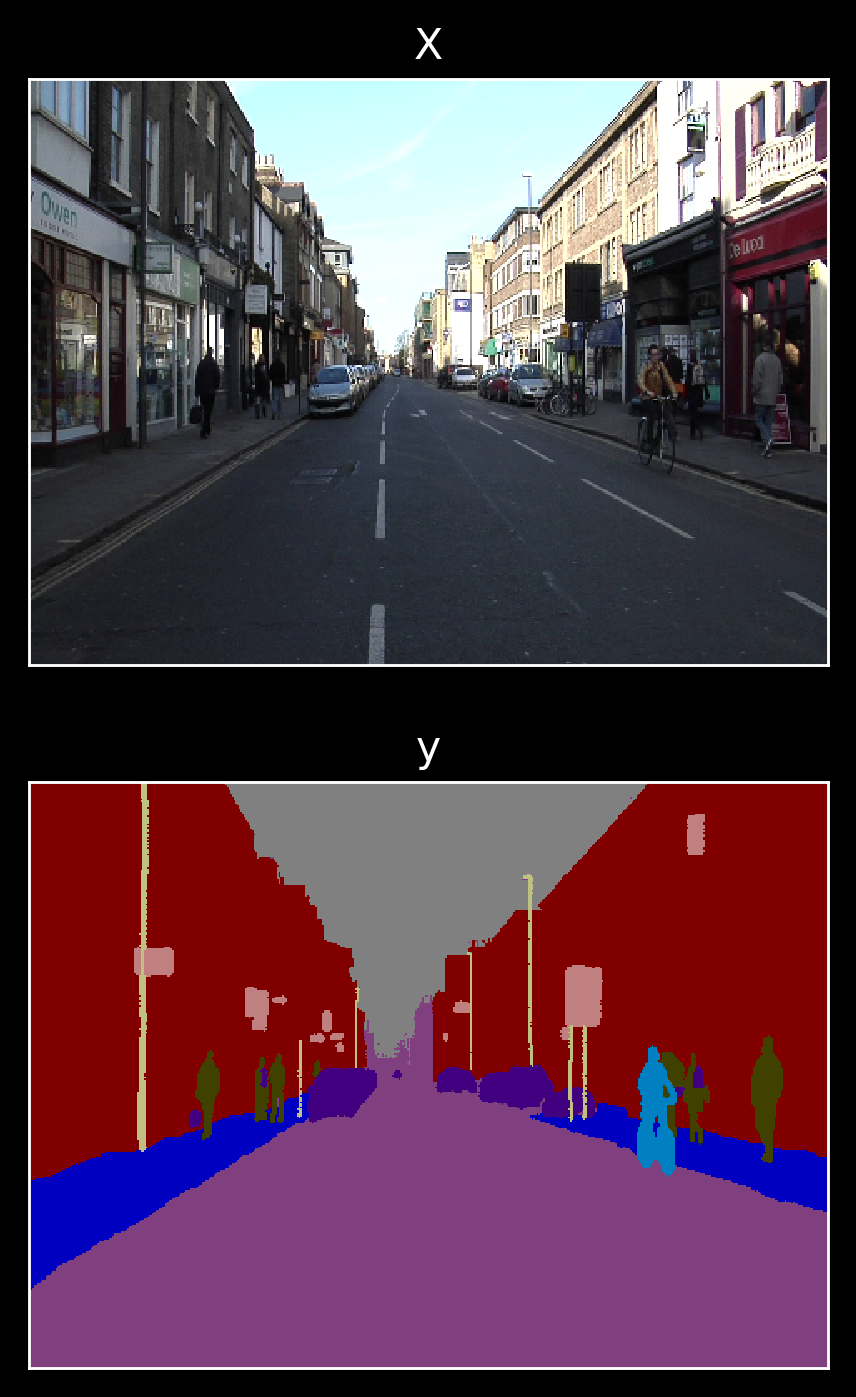

In [7]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0], order=['X', 'y'])

In [8]:
# build the model for the image shape and number of labels
model = segnet.build_segnet((*crop_size, 3), camvid11.n, 
    label_names=camvid11.discrete_to_label_map,
    class_weights=camvid11.class_weights,          
)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SegNet_input (InputLayer)    (None, 352, 480, 3)       0         
_________________________________________________________________
pixel_norm (Lambda)          (None, 352, 480, 3)       0         
_________________________________________________________________
lcn (ContrastNormalization)  (None, 352, 480, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 352, 480, 64)      1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 352, 480, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 352, 480, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 352, 480, 64)      36928     
__________

In [9]:
# create the callbacks for the training procedure
callbacks = [
    EarlyStopping(monitor='loss', patience=10),
    LearningRateScheduler(lambda _, lr: 0.95 * lr),
    ModelCheckpoint(weights_file, 
        monitor='val_acc', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='min'
    ),
    PlotMetrics(),
]

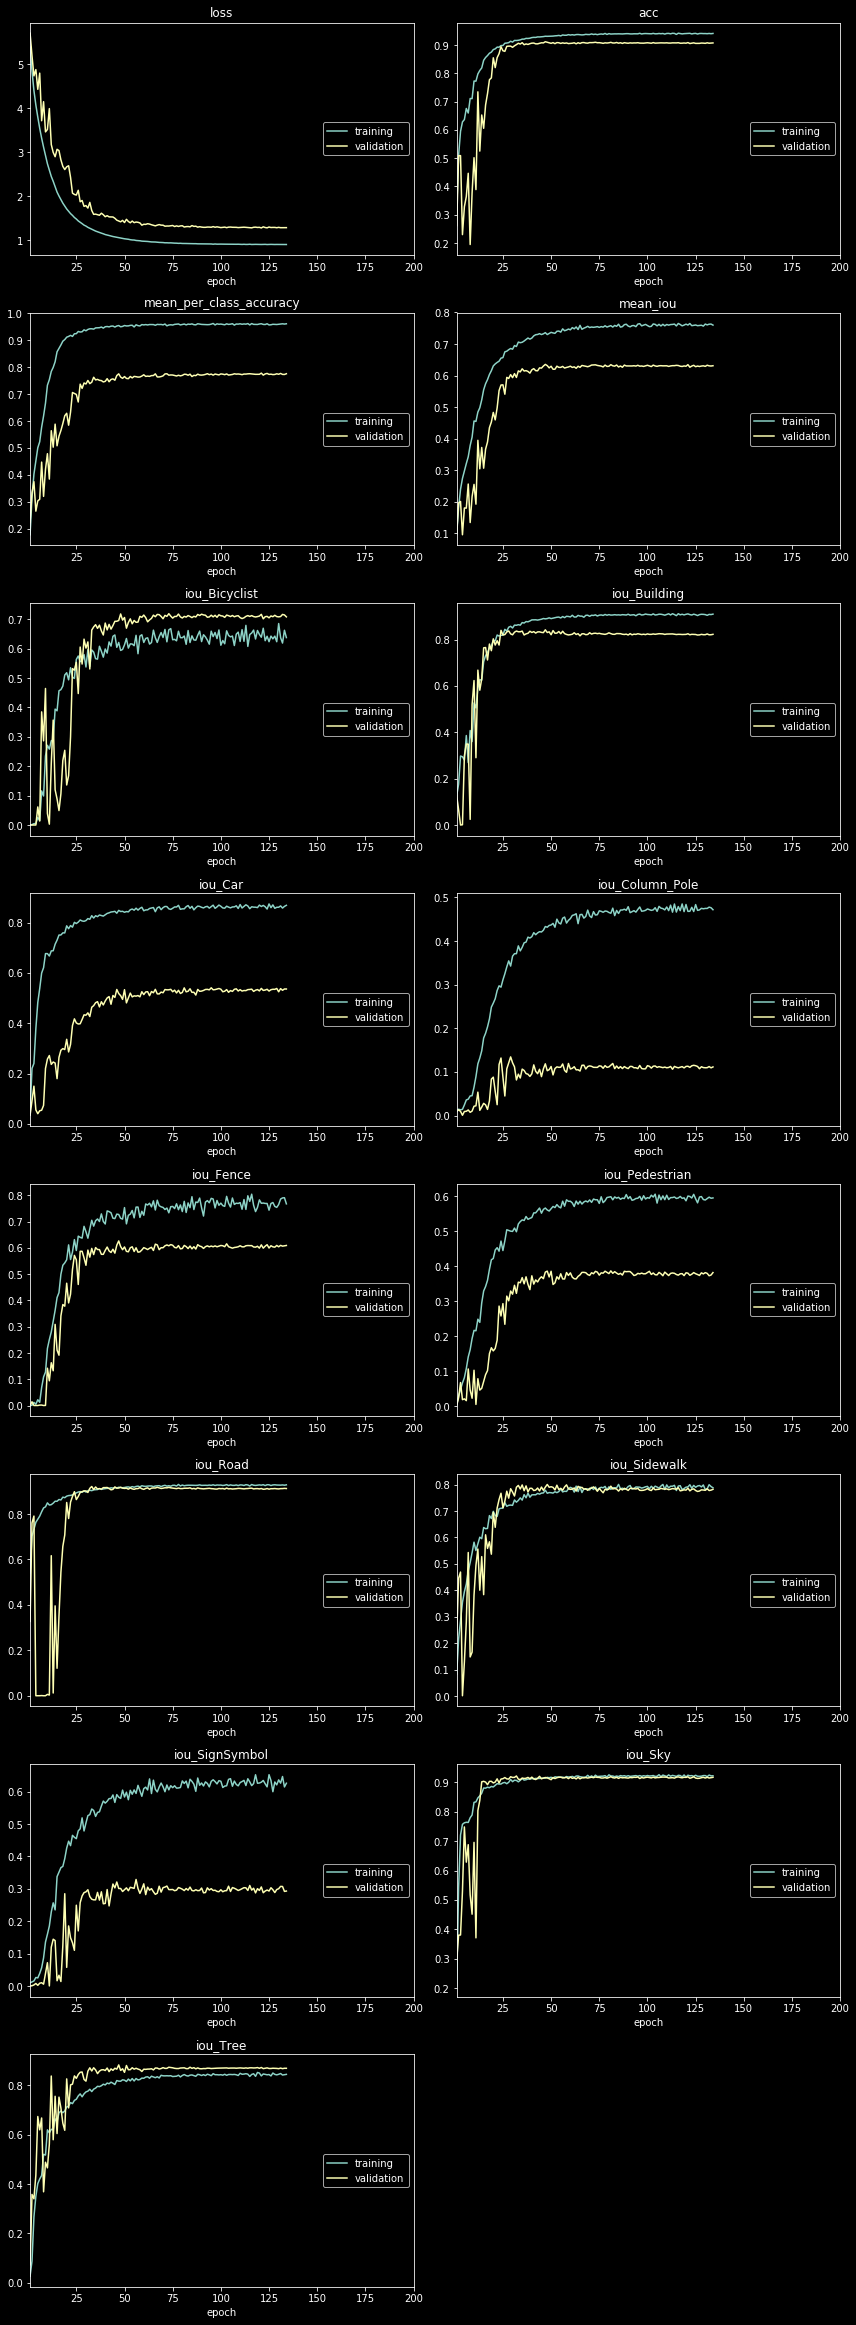

In [10]:
# fit the model with the data. divide the steps per epoch by the 
# batch size (which is 3 in this case)
history = model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / batch_size),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=0
)

In [11]:
history_to_results(history)

train       val
acc                      0.940680  0.907107
Bicyclist                0.637646  0.708189
Building                 0.909361  0.822377
Car                      0.868474  0.536016
Column_Pole              0.471842  0.111502
Fence                    0.767370  0.608977
Pedestrian               0.595118  0.381843
Road                     0.928102  0.911977
Sidewalk                 0.788220  0.782334
SignSymbol               0.625601  0.293148
Sky                      0.922418  0.917282
Tree                     0.844253  0.868886
loss                     0.900524  1.283448
mean_iou                 0.759855  0.631139
mean_per_class_accuracy  0.960840  0.775405

## Load Best Model

In [12]:
model.load_weights(weights_file)

# Test Metrics

In [13]:
metrics = model.evaluate_generator(generators['test'], steps=233)
names = model.metrics_names
pd.DataFrame(metrics, names, columns=['test'])

test
loss                     3.894888
acc                      0.225854
mean_per_class_accuracy  0.254341
mean_iou                 0.106974
iou_Bicyclist            0.012040
iou_Building             0.042028
iou_Car                  0.155595
iou_Column_Pole          0.012603
iou_Fence                0.000034
iou_Pedestrian           0.023489
iou_Road                 0.000092
iou_Sidewalk             0.180778
iou_SignSymbol           0.011818
iou_Sky                  0.655650
iou_Tree                 0.082586

# Qualitative Results

In [14]:
def predict(generator):
    X, y = next(generator)
    p = model.predict(X)
    return X, camvid11.unmap(y), camvid11.unmap(p)

### Train

In [15]:
X, y, p = predict(generators['train'])

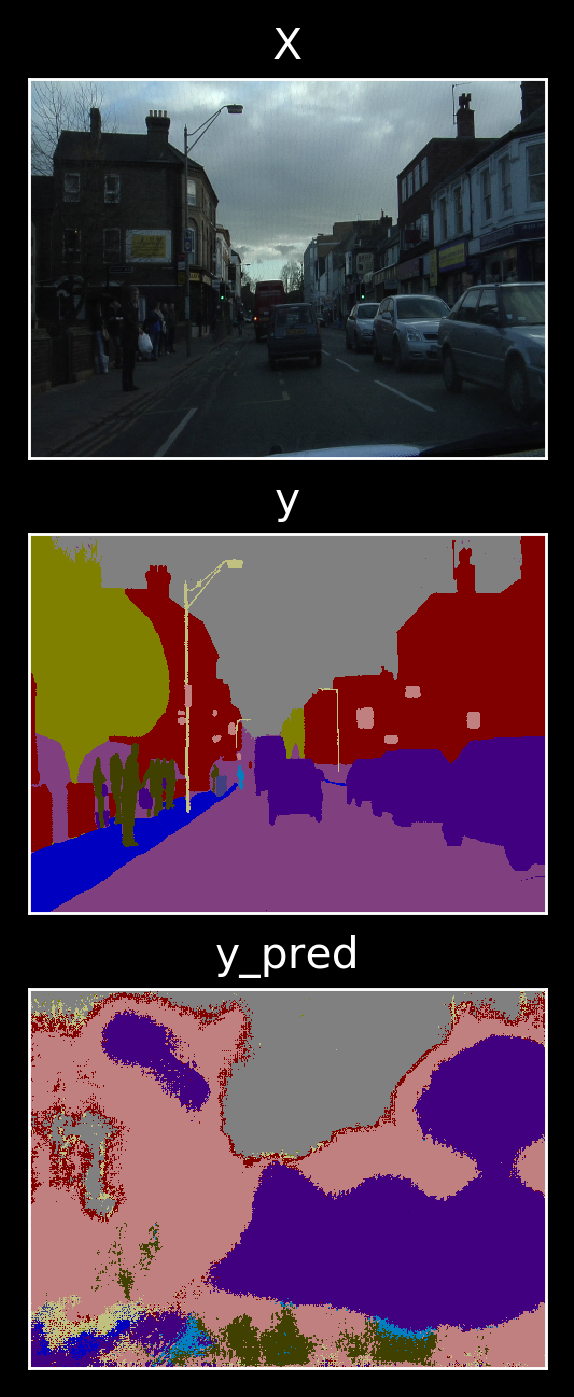

In [16]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

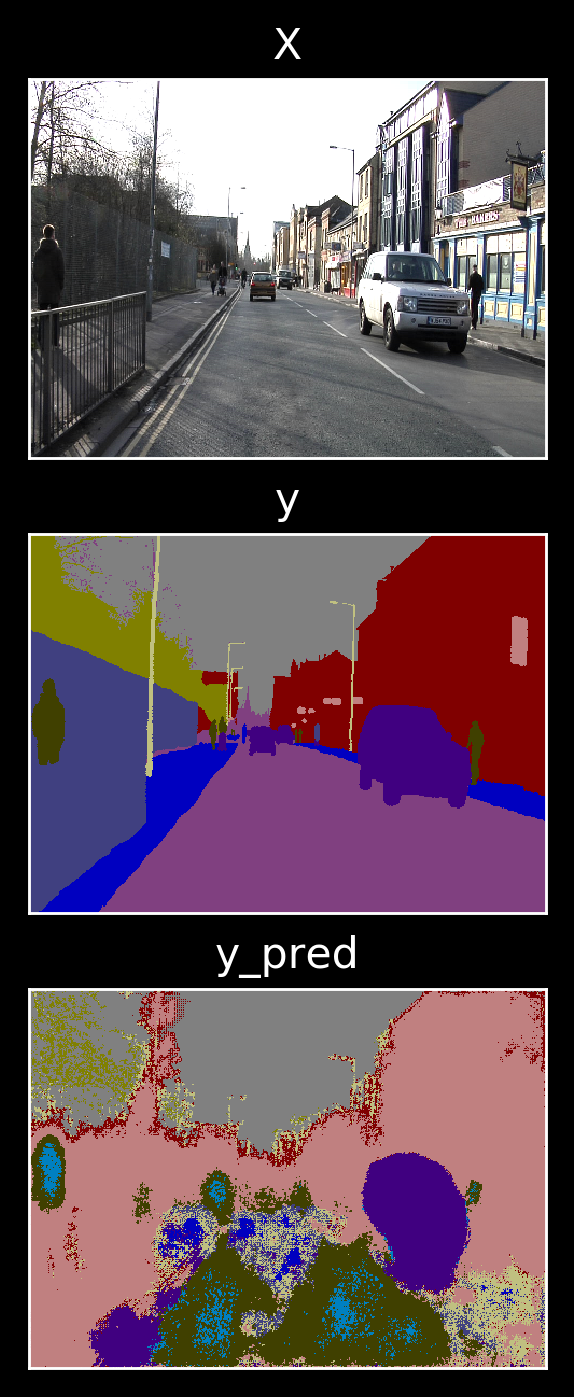

In [17]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1], order=['X', 'y', 'y_pred'])

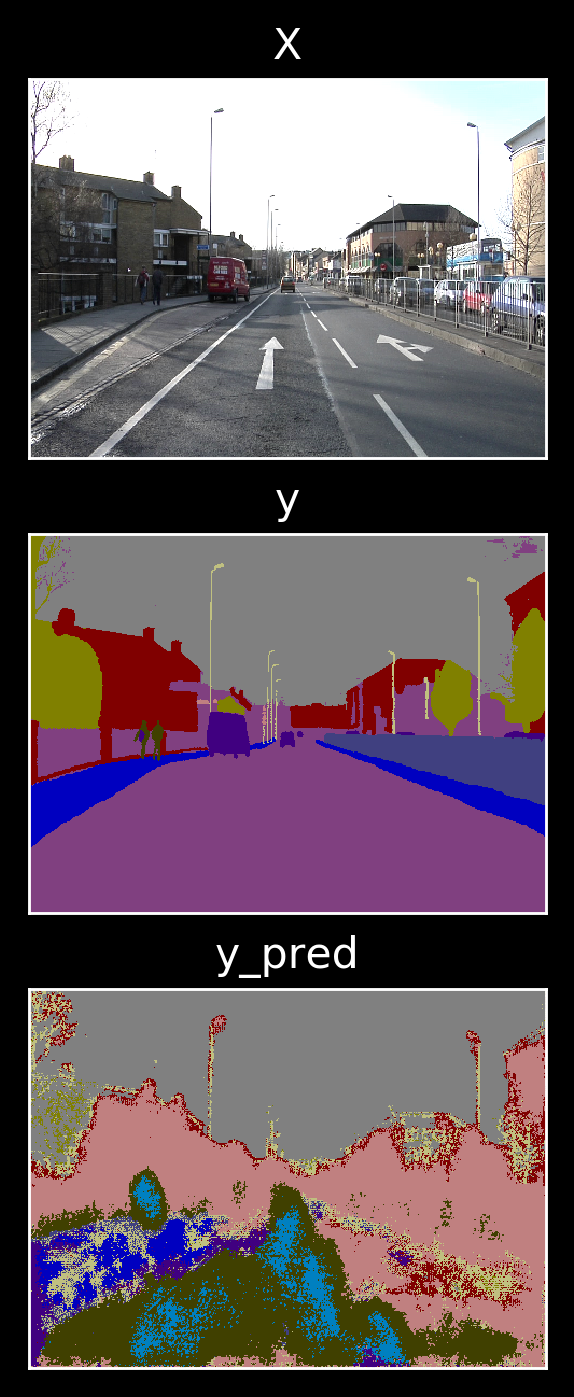

In [18]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2], order=['X', 'y', 'y_pred'])

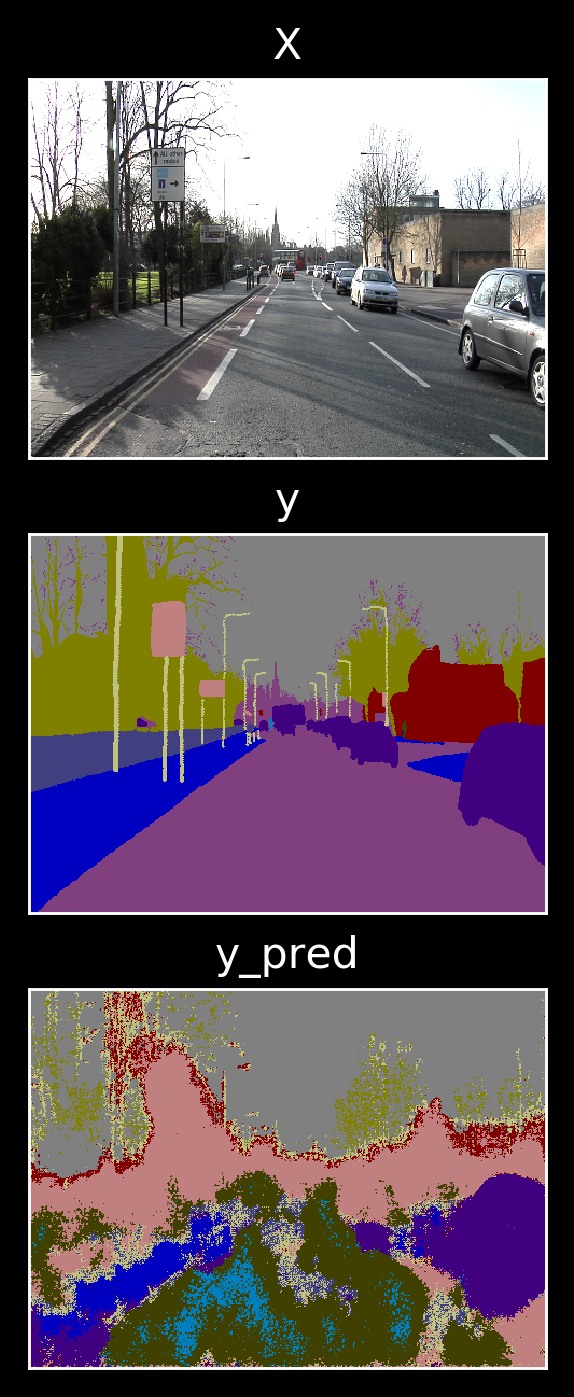

In [19]:
camvid.plot(X=X[3], y=y[3], y_pred=p[3], order=['X', 'y', 'y_pred'])

### Validation

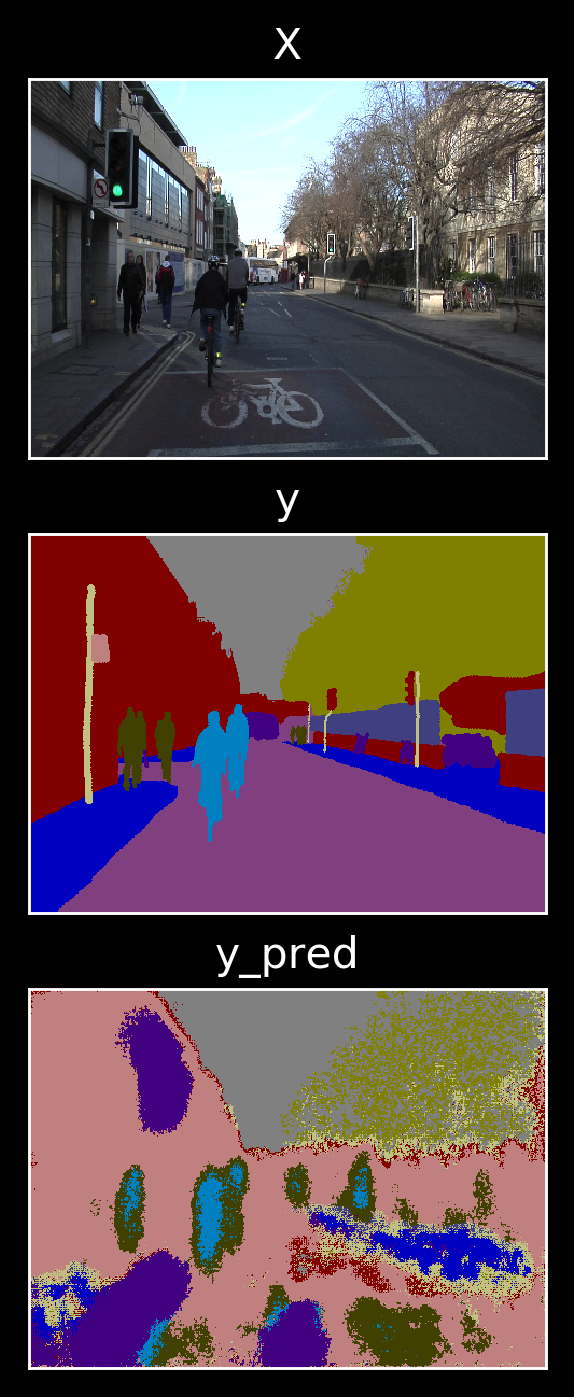

In [20]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

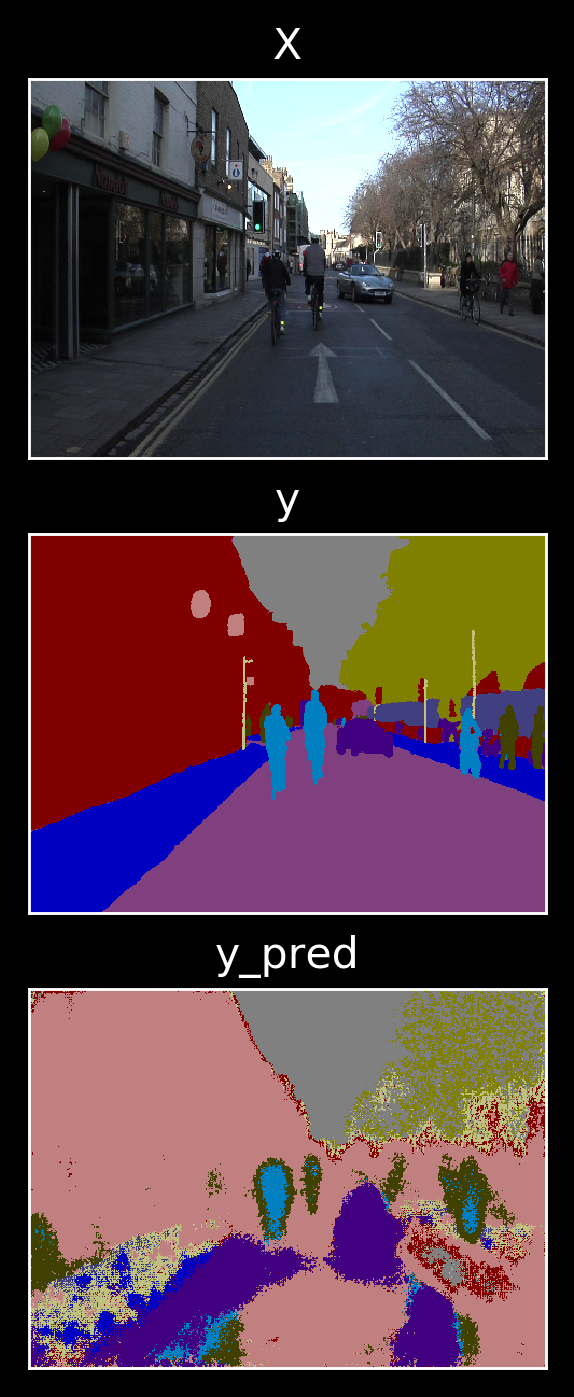

In [21]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

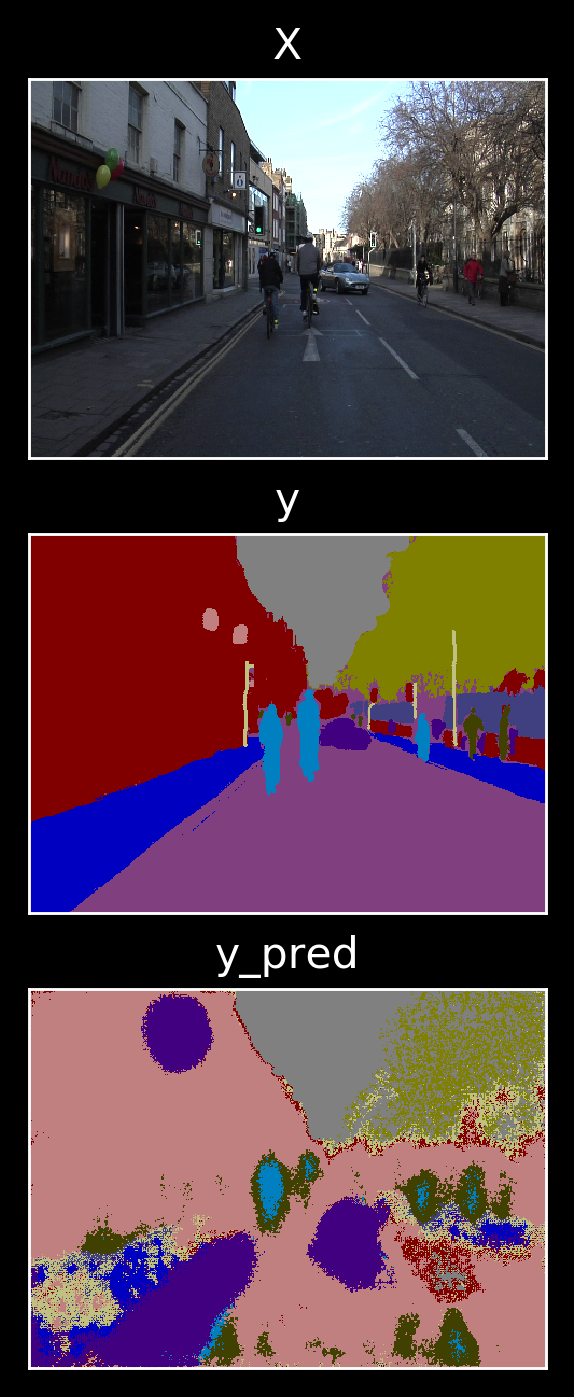

In [22]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

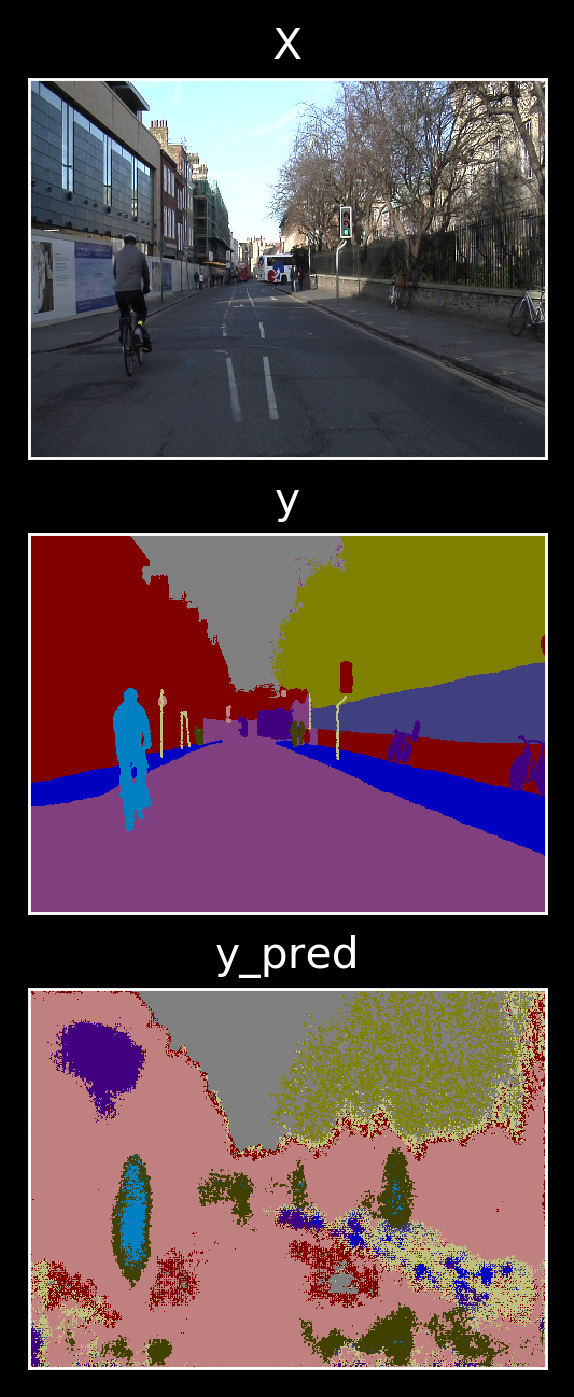

In [23]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Test

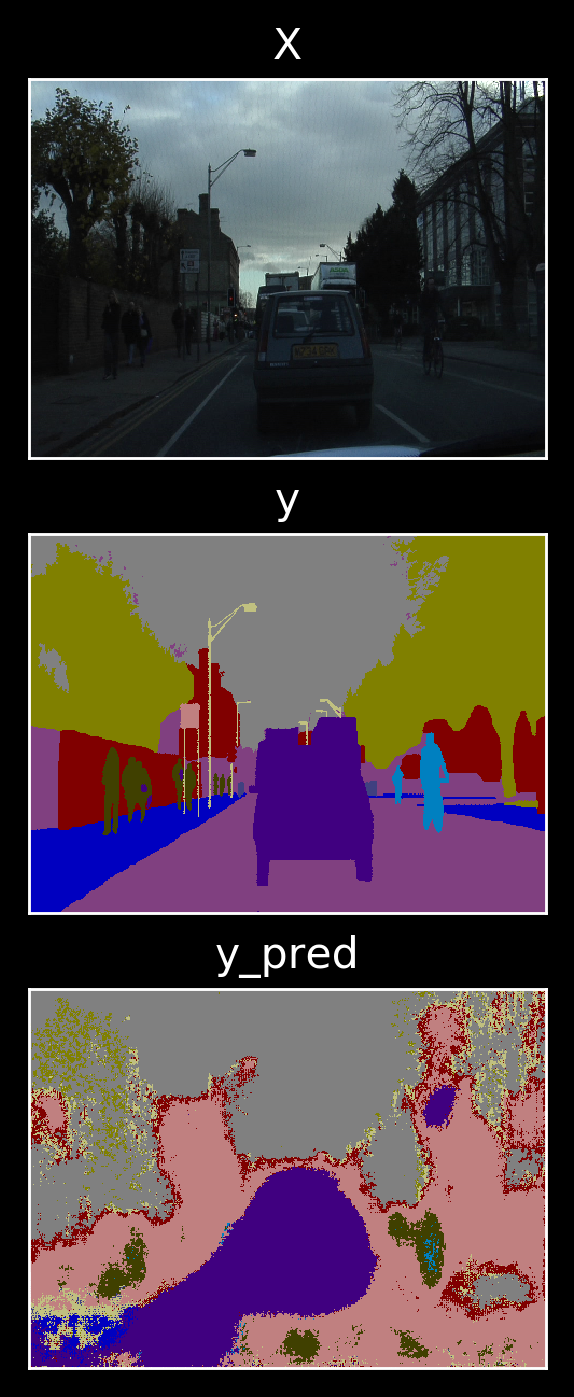

In [24]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

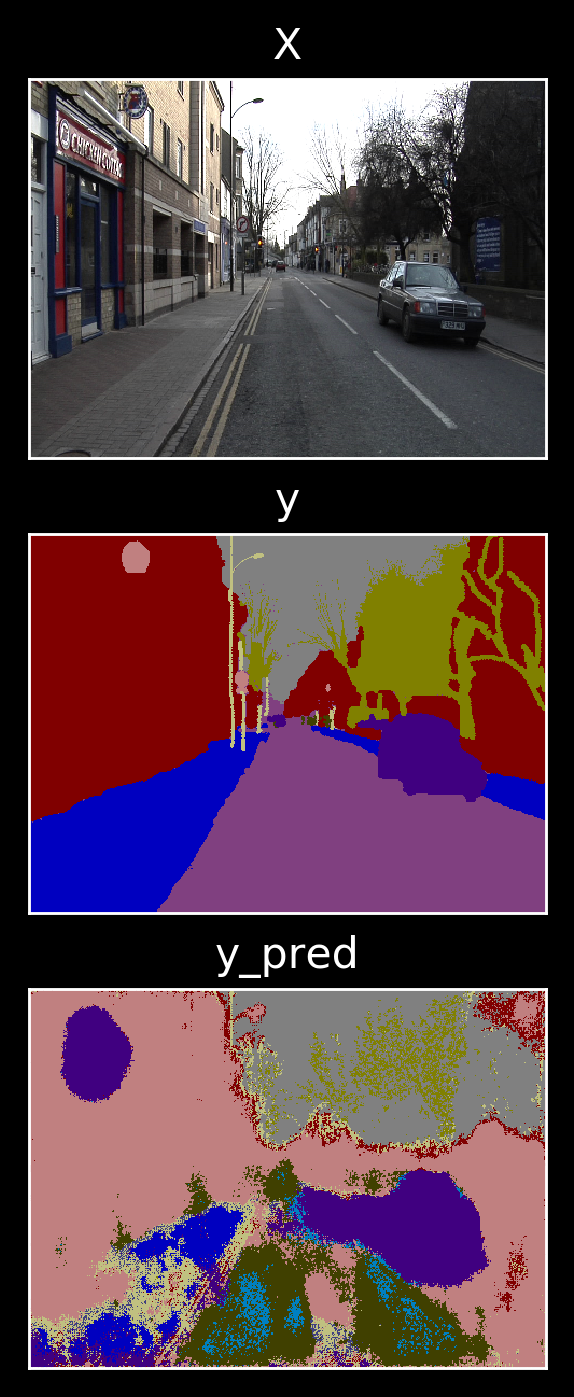

In [25]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

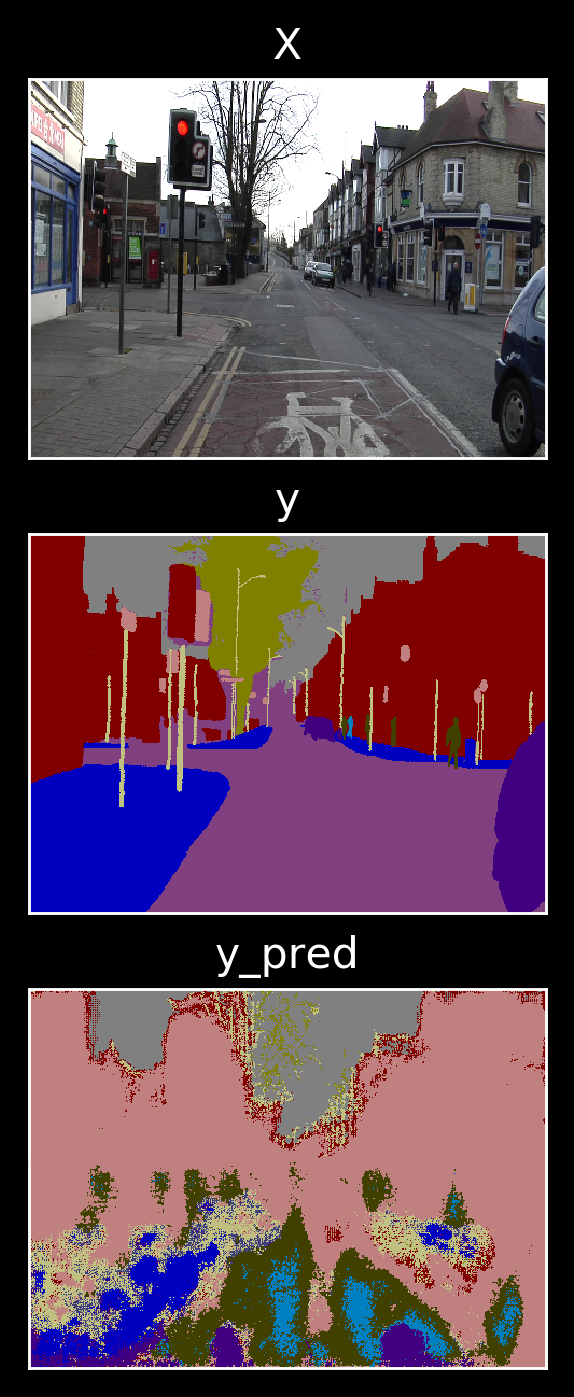

In [26]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

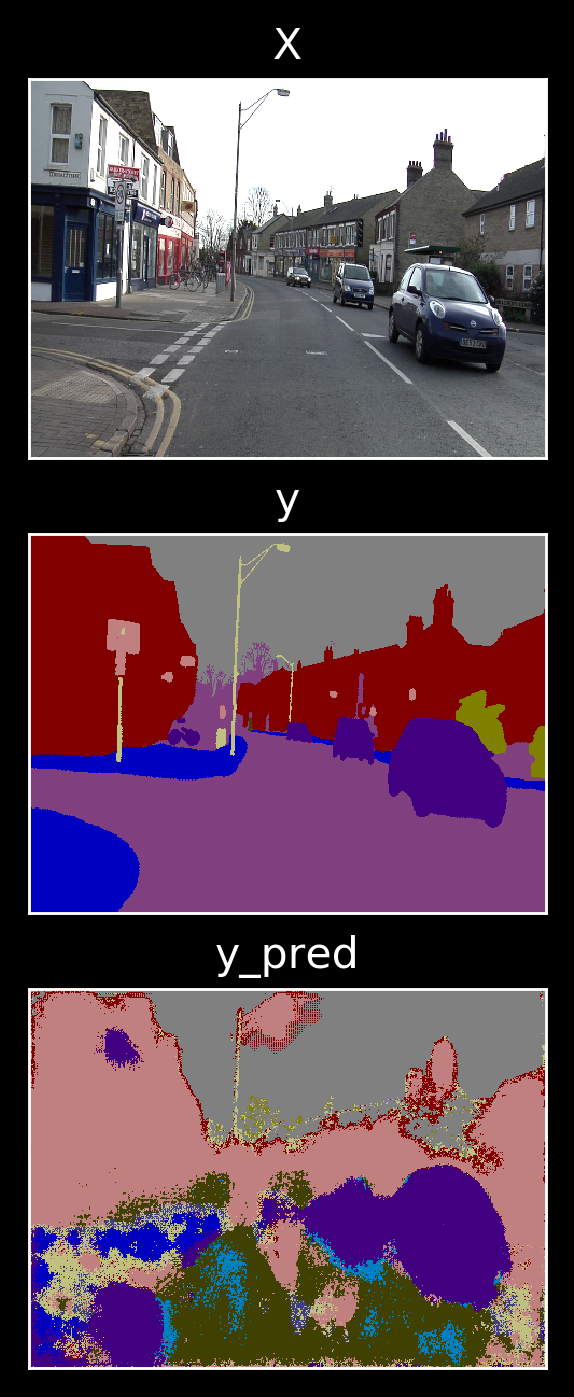

In [27]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])